In [93]:
import sys
sys.path.append("..")

import json

from pathlib import Path
from collections import defaultdict
from src.graph.load_gfa import load_gfa
from src.utils.params_from_path import params_from_path

import seaborn as snss
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(rc = {'figure.figsize':(10,8)})
# sns.set(rc = {'figure.figsize':(6,4)})

NSEQS = 50
NAME = f"{NSEQS}-sars-cov-2-ena"
PATH_SAVE = Path(f"../output-experiments-paper-review/sars-cov-2-{NSEQS}-row_maximal-vs-complete-blocks")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

## Fontsizes plots
FONTSIZE_TITLE = 18
FONTSIZE_SUBTITLE = 16
FONTSIZE_X = 16
FONTSIZE_Y = 16
FONTSIZE_TOOLS = 14 

FONTSIZE_GRID_TITLE = 18
FONTSIZE_GRID_SUBTITLE = 16
FONTSIZE_GRID_X = 16
FONTSIZE_GRID_Y = 16
FONTSIZE_GRID_TOOLS = 14 

LEGEND = True


In [94]:
def load_info_graph(path_gfa):
    info = dict()

    nodes, edges, paths, node_depth = load_gfa(path_gfa)

    info["n_nodes"] = len(nodes)
    info["n_edges"] = len(edges)

    # 2. length of the graph
    info["len_graph"] = sum([v["len"] for k,v in nodes.items()])

    # 3. number of potential seeds
    info["potential_seeds_len10"] = sum([v["len"] - 10 + 1 for k,v in nodes.items() if v["len"]>= 10])
    info["potential_seeds_len15"] = sum([v["len"] - 15 + 1 for k,v in nodes.items() if v["len"]>= 15])
    info["potential_seeds_len20"] = sum([v["len"] - 20 + 1 for k,v in nodes.items() if v["len"]>= 20])

    # 4. node depth
    info["nodes_depth_gt_03"] = len([k for k,v in node_depth.items() if v >= 0.3]) / len(nodes)

    return info

In [95]:
def get_info_from_exp(path_exp):
    info = []
    # config info from the experiment
    with open(Path(path_exp).joinpath("config.json"), "r") as fp:
        config = json.load(fp)
    decomposition = "complete" if config["DECOMPOSITION"]["STANDARD"] is True else "row-maximal"
    alpha_consistent = True if config["DECOMPOSITION"]["ALPHA_CONSISTENT"] is True else False

    # load info of graphs for each experiment
    path_graphs = Path(path_exp).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")
    for path in path_graphs:
        params = params_from_path(path, output_dict=True)
        params["alpha_consistent"] = alpha_consistent
        params["decomposition"] = decomposition
        params["path"] = path

        info_pb = load_info_graph(path)        
        params.update(info_pb)

        info.append(params)

    return pd.DataFrame(info)

### pggb


In [96]:
# sarscov2 
path_pggb = list(Path(f"../paper-graphs-tools/pggb/{NSEQS}-sars-cov-2-ena").rglob("*.gfa"))[0]
info_pggb = load_info_graph(path_pggb)
info_pggb

{'n_nodes': 404,
 'n_edges': 531,
 'len_graph': 30071,
 'potential_seeds_len10': 28568,
 'potential_seeds_len15': 27952,
 'potential_seeds_len20': 27374,
 'nodes_depth_gt_03': 0.6658415841584159}

### vg

In [97]:
# vg
path_vg = Path(f"../paper-graphs-tools/vg/{NSEQS}-sars-cov-2-ena.gfa")
info_vg =  load_info_graph(path_vg) 
info_vg

{'n_nodes': 392,
 'n_edges': 518,
 'len_graph': 29995,
 'potential_seeds_len10': 28522,
 'potential_seeds_len15': 27911,
 'potential_seeds_len20': 27338,
 'nodes_depth_gt_03': 0.6836734693877551}

#### founderblockgraph

In [98]:
path_fbg = Path(f"../paper-graphs-tools/founderblockgraph/{NSEQS}-sars-cov-2-ena.xgfa")
info_fbg = load_info_graph(path_fbg)
info_fbg

{'n_nodes': 3556,
 'n_edges': 3681,
 'len_graph': 31213,
 'potential_seeds_len10': 1268,
 'potential_seeds_len15': 68,
 'potential_seeds_len20': 44,
 'nodes_depth_gt_03': 0.9558492688413949}

#### make_prg

In [99]:
path_prg = Path(f"../paper-graphs-tools/make_prg/{NSEQS}-sars-cov-2-ena.prg.gfa")
info_prg = load_info_graph(path_prg)
info_prg

{'n_nodes': 364,
 'n_edges': 502,
 'len_graph': 33698,
 'potential_seeds_len10': 32195,
 'potential_seeds_len15': 31553,
 'potential_seeds_len20': 30947,
 'nodes_depth_gt_03': 0.0}

### pangeblocks

In [100]:
path_complete_experiment = f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-{NSEQS}-complete"
path_rowmaximal_experiment = f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-{NSEQS}-row_maximal"

path_graphs_standard = Path(path_complete_experiment).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")
path_graphs_rowmaximal = Path(path_rowmaximal_experiment).joinpath("gfa-unchop").rglob(f"*{NAME}.gfa")

In [101]:
df_graphs = pd.concat([
    get_info_from_exp(path_complete_experiment), 
    get_info_from_exp(path_rowmaximal_experiment)
    ], ignore_index=True)
df_graphs["objective_function"] = df_graphs["objective_function"].apply(lambda x: "blocks" if x=="nodes" else x)
df_graphs = df_graphs.query("alpha<170")
df_graphs.head()

,objective_function,penalization,min_coverage,min_len,alpha,alpha_consistent,decomposition,path,n_nodes,n_edges,len_graph,potential_seeds_len10,potential_seeds_len15,potential_seeds_len20,nodes_depth_gt_03
8,weighted,1000,0.0,20,96,False,complete,/data/analysis-paper/paper-experiment-decompos...,280,400,32348,31074,30474,29888,0.582143
10,weighted,1000,0.0,20,1,False,complete,/data/analysis-paper/paper-experiment-decompos...,376,499,30662,29265,28665,28094,0.662234
12,weighted,1000,0.0,20,102,False,complete,/data/analysis-paper/paper-experiment-decompos...,272,394,32746,31462,30852,30256,0.569853
15,weighted,1000,0.0,20,84,False,complete,/data/analysis-paper/paper-experiment-decompos...,285,409,32160,30848,30228,29622,0.582456
16,blocks,0,0.0,0,84,False,complete,/data/analysis-paper/paper-experiment-decompos...,284,406,31937,30634,30019,29418,0.577465


In [102]:
xpos_pggb = int(df_graphs.alpha.max()*1.05)
xpos_vg   = int(df_graphs.alpha.max()*1.05)
xpos_fbg = int(df_graphs.alpha.max()*1.05)
xpos_prg = int(df_graphs.alpha.max()*1.05)

In [103]:
feature = "n_nodes"
# min and max y-axis values
feat_min = min(df_graphs[feature].min(), info_pggb[feature], info_vg[feature], info_fbg[feature], info_prg[feature])
feat_max = max(df_graphs[feature].max(), info_pggb[feature], info_vg[feature], info_fbg[feature], info_prg[feature])
delta_range = feat_max - feat_min
ymin = feat_min - 0.1*delta_range 
ymax = feat_max + 0.1*delta_range

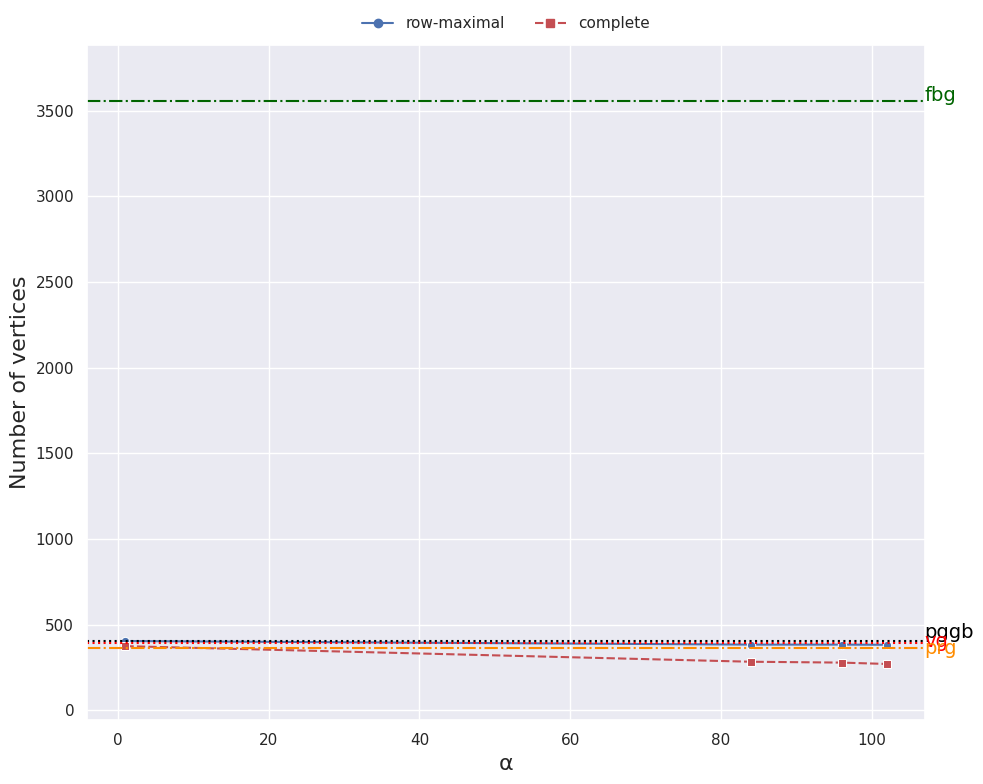

In [104]:
MARKERS=["o","s"] # o: circle , s: square
COLORS=["b","r"] # b: blue , r: red
DECOMPOSITIONS = ["row-maximal", "complete"]

g_nodes = sns.lineplot(
                    data=df_graphs.query("objective_function=='blocks'"),
                    x="alpha", 
                    y=feature, 
                    hue="decomposition", 
                    style="decomposition", 
                    markers=MARKERS, 
                    palette=COLORS,
                    style_order=DECOMPOSITIONS,
                    hue_order=DECOMPOSITIONS,
                    )

g_nodes.set_xlabel(f"{chr(945)}", fontsize=FONTSIZE_X)
g_nodes.set_ylabel("Number of vertices", fontsize=FONTSIZE_Y)
g_nodes.set_ylim([ymin,ymax])

# add pggb
g_nodes.axhline(y=info_pggb[feature], linestyle=":",color = "black", label="pggb")
g_nodes.text(x=xpos_pggb,y=info_pggb[feature]*1.05,s="pggb", color="black", fontdict=dict(fontsize=FONTSIZE_TOOLS))

# add vg
g_nodes.axhline(y=info_vg[feature], linestyle=":",color = "red", label="vg",)
g_nodes.text(x=xpos_vg,y=info_vg[feature]*0.95,s="vg", color="red", fontdict=dict(fontsize=FONTSIZE_TOOLS))

# add founderblockgraph
g_nodes.axhline(y=info_fbg[feature], linestyle="dashdot", color="darkgreen", label="fbg")
g_nodes.text(x=xpos_fbg, y=info_fbg[feature], s="fbg", color="darkgreen", fontdict=dict(fontsize=FONTSIZE_TOOLS))

# add make_prg
g_nodes.axhline(y=info_prg[feature], linestyle="dashdot", color="darkorange", label="prg")
g_nodes.text(x=xpos_prg, y=info_prg[feature]*0.9, s="prg", color="darkorange", fontdict=dict(fontsize=FONTSIZE_TOOLS))

sns.move_legend(
    g_nodes, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="", frameon=False,
)

g_nodes.figure.tight_layout()
g_nodes.get_figure().savefig(PATH_SAVE.joinpath(f"{NAME}-n_vertices-blocks.png"),dpi=300)

In [105]:
df_graphs.query("objective_function=='blocks'").groupby("decomposition").size()

decomposition
complete       4
row-maximal    4
dtype: int64

In [106]:
df_graphs.query("objective_function=='blocks'")

,objective_function,penalization,min_coverage,min_len,alpha,alpha_consistent,decomposition,path,n_nodes,n_edges,len_graph,potential_seeds_len10,potential_seeds_len15,potential_seeds_len20,nodes_depth_gt_03
16,blocks,0,0.0,0,84,False,complete,/data/analysis-paper/paper-experiment-decompos...,284,406,31937,30634,30019,29418,0.577465
19,blocks,0,0.0,0,102,False,complete,/data/analysis-paper/paper-experiment-decompos...,271,394,32523,31248,30643,30052,0.564576
23,blocks,0,0.0,0,1,False,complete,/data/analysis-paper/paper-experiment-decompos...,375,498,30439,29051,28456,27890,0.661333
24,blocks,0,0.0,0,96,False,complete,/data/analysis-paper/paper-experiment-decompos...,279,400,32125,30860,30265,29684,0.577061
82,blocks,0,0.0,0,102,False,row-maximal,/data/analysis-paper/paper-experiment-decompos...,383,509,30959,29362,28673,28020,0.642298
83,blocks,0,0.0,0,96,False,row-maximal,/data/analysis-paper/paper-experiment-decompos...,384,510,30860,29270,28586,27938,0.643229
86,blocks,0,0.0,0,84,False,row-maximal,/data/analysis-paper/paper-experiment-decompos...,384,510,30860,29270,28586,27938,0.643229
94,blocks,0,0.0,0,1,False,row-maximal,/data/analysis-paper/paper-experiment-decompos...,405,531,30072,28570,27954,27376,0.661728
